In [16]:
import lightgbm as lgb
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import import_ipynb
import features

In [12]:
if 'ygong' in os.getcwd():
    filepath = "../data"
    dir_out = "../output"
else:
    filepath = "/home/gong/Documents/Kaggle_July2019/data"
    dir_out = "/home/gong/Documents/Kaggle_July2019/output"

In [49]:
# drop irrelevant columns
drop_list = ['id', 'molecule_name', 'atom_0', 'atom_1', 'type']
X = data.drop(columns=['scalar_coupling_constant'] + drop_list)
y = data['scalar_coupling_constant']
data_submit = data_submit.drop(columns=drop_list)

AttributeError: 'PrepareData' object has no attribute 'get_features'

In [13]:
# cross-validation
params = {'num_leaves': 50, 
          'min_child_samples': 79,
          'min_data_in_leaf': 100,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0,
         }

reg_model = lgb.LGBMRegressor(**params)
scores = []
cv = KFold(n_splits=10, random_state=42)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index)
    print("Test Index: ", test_index, "\n")

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    reg_model.fit(X_train, y_train)
    scores.append(reg_model.score(X_test, y_test))
print('scores: \n {}'.format(scores))

Train Index:  [ 465815  465816  465817 ... 4658144 4658145 4658146]
Test Index:  [     0      1      2 ... 465812 465813 465814] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [465815 465816 465817 ... 931627 931628 931629] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [ 931630  931631  931632 ... 1397442 1397443 1397444] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [1397445 1397446 1397447 ... 1863257 1863258 1863259] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [1863260 1863261 1863262 ... 2329072 2329073 2329074] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [2329075 2329076 2329077 ... 2794887 2794888 2794889] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [2794890 2794891 2794892 ... 3260702 3260703 3260704] 

Train Index:  [      0       1       2 ... 4658144 46

Train score: 0.9950092854038364
Test score: 0.995613048947929


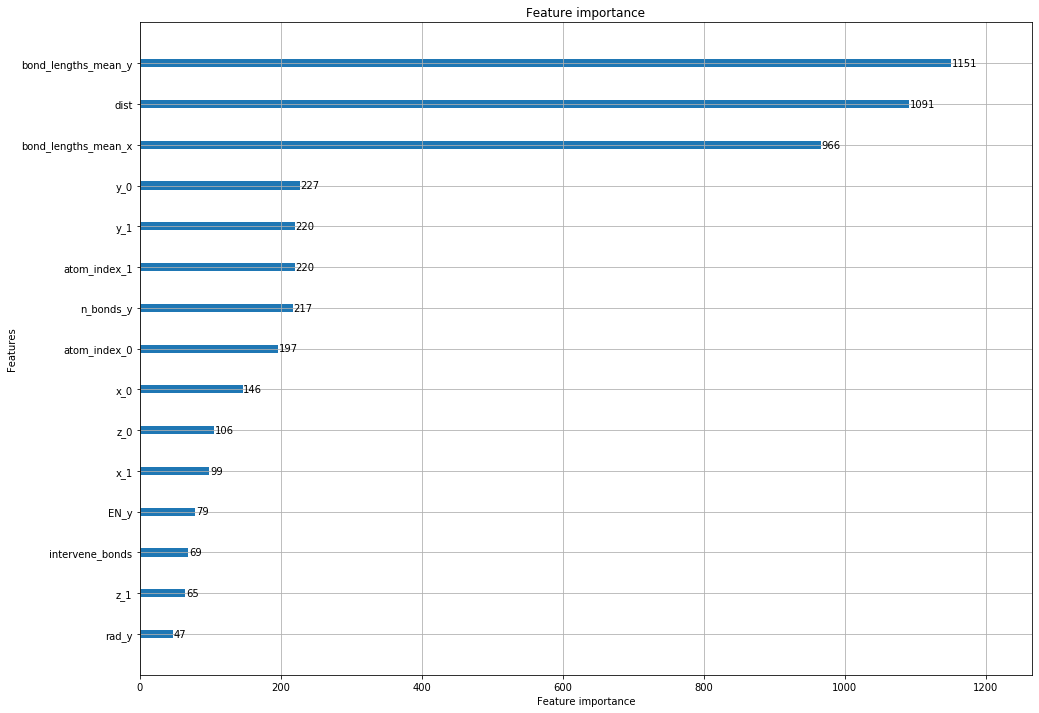

The mean absolute deviation is 0.4603463509618297


In [14]:
y_predict = reg_model.predict(X_test)
print('Train score: {}'.format(reg_model.score(X_train, y_train)))
print('Test score: {}'.format(reg_model.score(X_test, y_test)))

fig, axes = plt.subplots()
fig.set_size_inches(16, 12)
lgb.plot_importance(reg_model, ax=axes)
plt.show()

# print MAE
error = mean_absolute_error(y_test, y_predict)
print('The mean absolute deviation is {}'.format(np.log(error)))

In [15]:
y_predict_lgb = reg_model.predict(data_submit)
submit = pd.read_csv(os.path.join(filepath, 'sample_submission.csv')).drop(columns='scalar_coupling_constant')
submit['scalar_coupling_constant'] = y_predict_lgb
submit.to_csv(os.path.join(dir_out, 'submission.csv'), index=False)

In [13]:
import subprocess
#subprocess.check_output(['ls','-l']) #all that is technically needed...
print(subprocess.check_output(['pwd']))
subprocess.call(['sh', './submit.sh'])

b'/home/gong/Documents/Kaggle_July2019/code\n'


1